# Correlation
`06_corr.ipynb`

## 정의
두 변수 간에 서로 얼마나 함께 변하는지 정도를 나타내는 통계 개념
- 값의 범위: -1 ~ +1
    - +1: 완벽한 양의 상관관계: y는 x에 비례해서 증가한다.(키 - 몸무게)
    - 0: 상관없음(키 - 수학점수)
    - -1: 완벽한 음의 상관관계: y는 x에 반비례하여 감소(운동량 - 체지방)

## 상관계수($r$)
두 변수 간 관계가 얼마나 강한지 측정한 지표.
> 일단 여기는 연속-연속
- ***피어슨(Pearson)***: ++가장 많이 쓰임++. 연속 변수 선형 관계 측정
- 스피어맨(Spearman): 순위 기반, 비선형 관계, 이상치에 강함
- 켄달(Kendall): 순위 일관성 기반, 표본이 적을 때 안정적

In [ ]:
# %pip install -q 'kagglehub[pandas-datasets]'

In [ ]:
import numpy as np
import pandas as pd

df = pd.read_csv('OnlineRetail.csv', encoding='ISO-8859-1')
# 유럽쪽 성조? 표기 때문에 쓰는 거라고.

df.head()

In [ ]:
from da_utils import profile, outliers, pattern

profile.get_data_profile(df)


In [ ]:
pattern.analyze_missing_patterns(df)

In [ ]:
outliers.outlier_detection(df, 0.999, iso_cont='auto', final_threshold=2)

In [ ]:
df.isna().sum()
# InvoiceoNo가 유니크한지 확인

print('전체 거래', len(df)) # 한 주문 안에 여러 종류를 주문.
print('고유 InvoiceNo', df['InvoiceNo'].nunique()) # 총 주문 수
print('고유 고객수', df['CustomerID'].nunique())
# 결론: Primary Key가 없음. 조합해서 써야 함.
# 헉. Primary Key는 종종 없을 수 있음.

In [ ]:
# 데이터 전처리
from traceback import print_tb

from matplotlib.pylab import f


df_clean = df.copy()

# CustomerID 결측값 제거
missing_customers = df_clean['CustomerID'].isnull().sum()
print(f'CustomerID 결측값 제거: {missing_customers}건')
df_clean = df_clean.dropna(subset=['CustomerID'])
len(df_clean) # 406829

# 취소 거래 분리(InvoiceNo가 'c'로 시작)
cancel_mask = df_clean['InvoiceNo'].astype('str').str.startswith('C')
df_cancel = df_clean[cancel_mask] # 8905
df_clean = df_clean[~cancel_mask] # 397924
print(f'취소거래분리: {len(df_cancel)}건')
print(f'정상거래: {len(df_clean)}건')

# 파생변수 생성(상관관계 분석을 위해)
# df.info() # 컬럼 확인
# TotalAmount, InvoiceDate DT로 변경, Year, Month, DayofWeek, DayName, Hour, InvoiceTotalAmount(이건 내 혼자), CustomerID(str)
df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['UnitPrice']
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
# My 오답: df_clean['Year'] = df_clean['InvoiceDate'].dt.to_period('Y')
df_clean['Year'] = df_clean['InvoiceDate'].dt.year
# My 오답: df_clean['Month'] = df_clean['InvoiceDate'].dt.to_period('M')
df_clean['Month'] = df_clean['InvoiceDate'].dt.month
df_clean['DayOfWeek'] = df_clean['InvoiceDate'].dt.day_of_week
df_clean['DayName'] = df_clean['InvoiceDate'].dt.day_name()
df_clean['Hour'] = df_clean['InvoiceDate'].dt.hour

df_clean['CustomerID'] = df_clean['CustomerID'].astype('Int64')
df_clean['CustomerID'] = df_clean['CustomerID'].astype(str)
# 한 줄로 하려면: df_clean['CustomerID'] = df_clean['CustomerID'].astype(int).astype(str)
df_clean['InvoiceTotal'] = df_clean.groupby('InvoiceNo')['TotalAmount'].transform('sum')
df_clean.head()

df_clean.groupby(['StockCode', 'Year'])['TotalAmount'].mean().unstack()

for_g = df_clean.groupby(['Hour'])['TotalAmount'].mean()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for_g.plot()


In [ ]:
print('=== 이상값 확인 ===')
print(f'음수 수량: {(df_clean['Quantity'] < 0).sum()}')
print(f'음수 단가: {(df_clean['UnitPrice'] < 0).sum()}')
print(f'0 단가: {(df_clean['UnitPrice'] == 0).sum()}') # 40.(있네??)
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]
print(f'0 단가: {(df_clean['UnitPrice'] == 0).sum()}') # 이제 없음.

df_clean

In [167]:
# 고객별 구매패턴
from pandas import qcut, to_datetime


print('=== 고객별 구매 패턴 특성 DF 생성 ===')
customer_stats = df_clean.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique', # 구매횟수 # count 아님.
    'Quantity': ['sum', 'mean'],# 총구매량, 평균구매량
    'UnitPrice': 'mean',
    'TotalAmount': ['sum', 'mean'],
    'StockCode': 'nunique', # count 아님
    'InvoiceDate': ['min', 'max'], 
}).round(2)


customer_stats.columns = ['구매횟수', '총구매량', '평균구매량', '평균단가', 
                        '총구매액', '평균구매액', '상품종류수', '첫구매일', '마지막구매일']

# 구매 기간 및 주기 계산
customer_stats['구매기간일수'] = (customer_stats['마지막구매일'] - customer_stats['첫구매일']).dt.days + 1
customer_stats['구매주기'] = (customer_stats['구매기간일수'] / customer_stats['구매횟수']).round(2)
# 반대로 썼었네 ㅋㅎ

# RFM 분석을 위한 변수 추가
# Recency: 최근 구매일로부터의 일수
# customer_stats['Recency']
"""이 아래는 내 식"""
# analyze_date = pd.Timestamp.now()
# analyze_date = pd.to_datetime(analyze_date).date()
# date_period = analyze_date - customer_stats['마지막구매일'].dt.date
""" 여기까지 """

analyze_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1) # 전체의 마지막 날에 하루 더한 것.
customer_stats['Recency'] = (analyze_date - customer_stats['마지막구매일']).dt.days # 얜 또 dt.days 되네 ㅅㅂㅅㅂㅅㅂ
# date_period.dt.days # 왜 안 되냐
customer_stats['Frequency'] = customer_stats['구매횟수']
customer_stats['Monetary'] = customer_stats['총구매액']

# RFM 점수
customer_stats['R_score'] = pd.qcut(customer_stats['Recency'], 5, labels=[5, 4, 3, 2, 1])
customer_stats['F_score'] = pd.qcut(customer_stats['Frequency'].rank(method='first'), 5, labels=[5, 4, 3, 2, 1])
customer_stats['M_score'] = pd.qcut(customer_stats['Monetary'], 5, labels=[5, 4, 3, 2, 1])
customer_stats['RFM_score'] = (customer_stats['R_score'].astype(str) + \
                               customer_stats['F_score'].astype(str) + \
                                customer_stats['M_score'].astype(str))

# 평균 장바구니 크기 # 맞나????
"""This is my 답"""
# df_clean['OrderSize'] = df_clean.groupby('InvoiceNo')['Quantity'].transform('sum')
# customer_stats['avg_order_size'] = df_clean.groupby('CustomerID')['OrderSize'].mean().round(2)
# df_clean.groupby(['CustomerID', "InvoiceNo"])['Quantity'].agg({
#     'sum', 'mean', 'count'
# })
# # 거래당 상품 종류
# df_clean
# df_clean.groupby('InvoiceNo')['StockCode'].count()
customer_stats['평균장바구니크기'] = customer_stats['총구매량'] / customer_stats['Frequency']
customer_stats['거래당상품종류'] = customer_stats['상품종류수'] / customer_stats['Frequency']

# 가격 민감도: 가격변화에 얼마나 민감하게 반응하는지.
# 단가가 상대적으로 일관되게 유지되는가? 높으면 다양한 가격대로 산다. 낮으면 특정 가격대에 고정적으로 구매한다.
# CV = Coefficient of Variation: 표준편차를 평균으로 나눔.
price_cv = df_clean.groupby('CustomerID')['UnitPrice'].agg(['mean', 'std'])
price_cv['가격변동성'] = (price_cv['std'] / price_cv['mean']).fillna(0)

# 사실 제대로 하려면 상품별 가격민감도를 찾는 게 맞음.

customer_stats = customer_stats.merge( # 병합 기준이 column이 아니라 Index임.
    price_cv[['가격변동성']], # 왜 괄호가 두 개인가? merge는 df + df임.
    left_index=True, # customer_stats의 인덱스 기준으로 병합
    right_index=True # price_cv의 인덱스 기준 병합
) 
display(customer_stats)


=== 고객별 구매 패턴 특성 DF 생성 ===


,구매횟수,총구매량,평균구매량,평균단가,총구매액,평균구매액,상품종류수,첫구매일,마지막구매일,구매기간일수,...,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM_score,평균장바구니크기,거래당상품종류,가격변동성
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346,1,74215,74215.00,1.04,77183.60,77183.60,1,2011-01-18 10:01:00,2011-01-18 10:01:00,1,...,326,1,77183.60,1,5,1,151,74215.000000,1.000000,0.000000
12347,7,2458,13.51,2.64,4310.00,23.68,103,2010-12-07 14:57:00,2011-12-07 15:52:00,366,...,2,7,4310.00,5,1,1,511,351.142857,14.714286,0.853015
12348,4,2341,75.52,5.76,1797.24,57.98,22,2010-12-16 19:09:00,2011-09-25 13:13:00,283,...,75,4,1797.24,2,2,2,222,585.250000,5.500000,2.324492
12349,1,631,8.64,8.29,1757.55,24.08,73,2011-11-21 09:51:00,2011-11-21 09:51:00,1,...,19,1,1757.55,4,5,2,452,631.000000,73.000000,4.225823
12350,1,197,11.59,3.84,334.40,19.67,17,2011-02-02 16:01:00,2011-02-02 16:01:00,1,...,310,1,334.40,1,5,4,154,197.000000,17.000000,2.430180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280,1,45,4.50,4.76,180.60,18.06,10,2011-03-07 09:52:00,2011-03-07 09:52:00,1,...,278,1,180.60,1,4,5,145,45.000000,10.000000,0.518798
18281,1,54,7.71,5.62,80.82,11.55,7,2011-06-12 10:53:00,2011-06-12 10:53:00,1,...,181,1,80.82,1,4,5,145,54.000000,7.000000,1.383397
18282,2,103,8.58,5.20,178.05,14.84,12,2011-08-05 13:35:00,2011-12-02 11:43:00,119,...,8,2,178.05,5,3,5,535,51.500000,6.000000,0.937819


In [168]:
print('=== 기본 상관관계 분석 ===')

# 수치형끼리 상관관계 분석.
numeric_cols =  ['총구매량', '평균구매량', '평균단가',
                   '평균구매액', '상품종류수', '구매기간일수', '구매주기', 'Recency', 
                   'Frequency', 'Monetary', '평균장바구니크기', '거래당상품종류', '가격변동성']

correlation_data = customer_stats[numeric_cols]


=== 기본 상관관계 분석 ===


AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

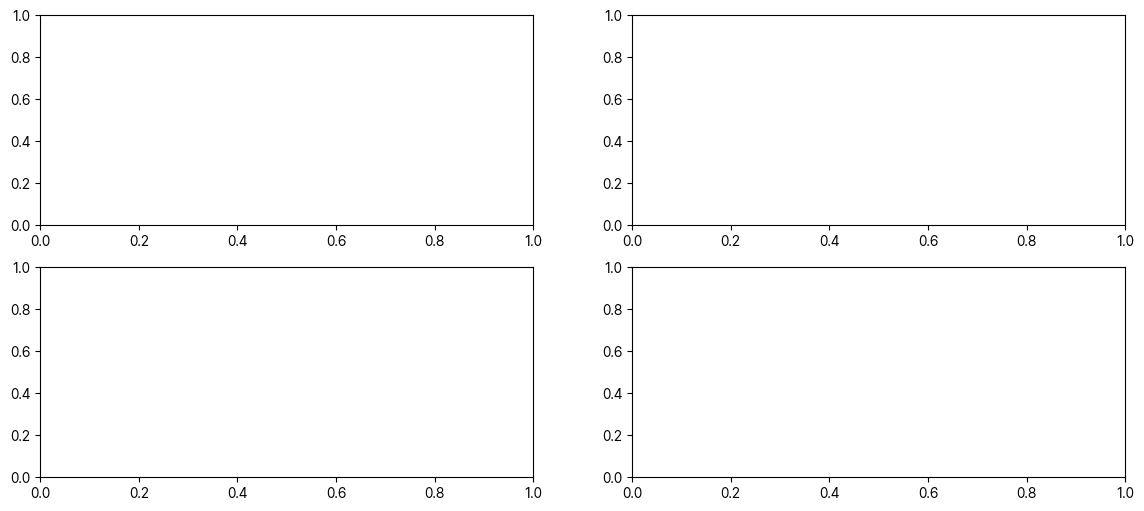

In [169]:
pearson_corr = correlation_data.corr(method='pearson')

spearman_corr = correlation_data.corr(method='spearman')


fig, axes = plt.subplots(2, 2, figsize=(14, 6))


# 1) Pearson heatmap
im1 = axes[0].imshow(pearson_corr, aspect='equal')
axes[0].set_title('Pearson Correlation')
axes[0].set_xticks(range(len(pearson_corr.columns)))
axes[0].set_xticklabels(pearson_corr.columns, rotation=90)
axes[0].set_yticks(range(len(pearson_corr.index)))
axes[0].set_yticklabels(pearson_corr.index)
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# 2) Spearman heatmap
im2 = axes[1].imshow(spearman_corr, aspect='equal')
axes[1].set_title('Spearman Correlation')
axes[1].set_xticks(range(len(spearman_corr.columns)))
axes[1].set_xticklabels(spearman_corr.columns, rotation=90)
axes[1].set_yticks(range(len(spearman_corr.index)))
axes[1].set_yticklabels(spearman_corr.index)
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


===주요 상관관계 발견사항 ===
가장 강한 양의 상관관계: 0.970
  평균구매량 x 평균장바구니크기
가장 강한 음의 상관관계: -0.514
  구매기간일수 x Recency


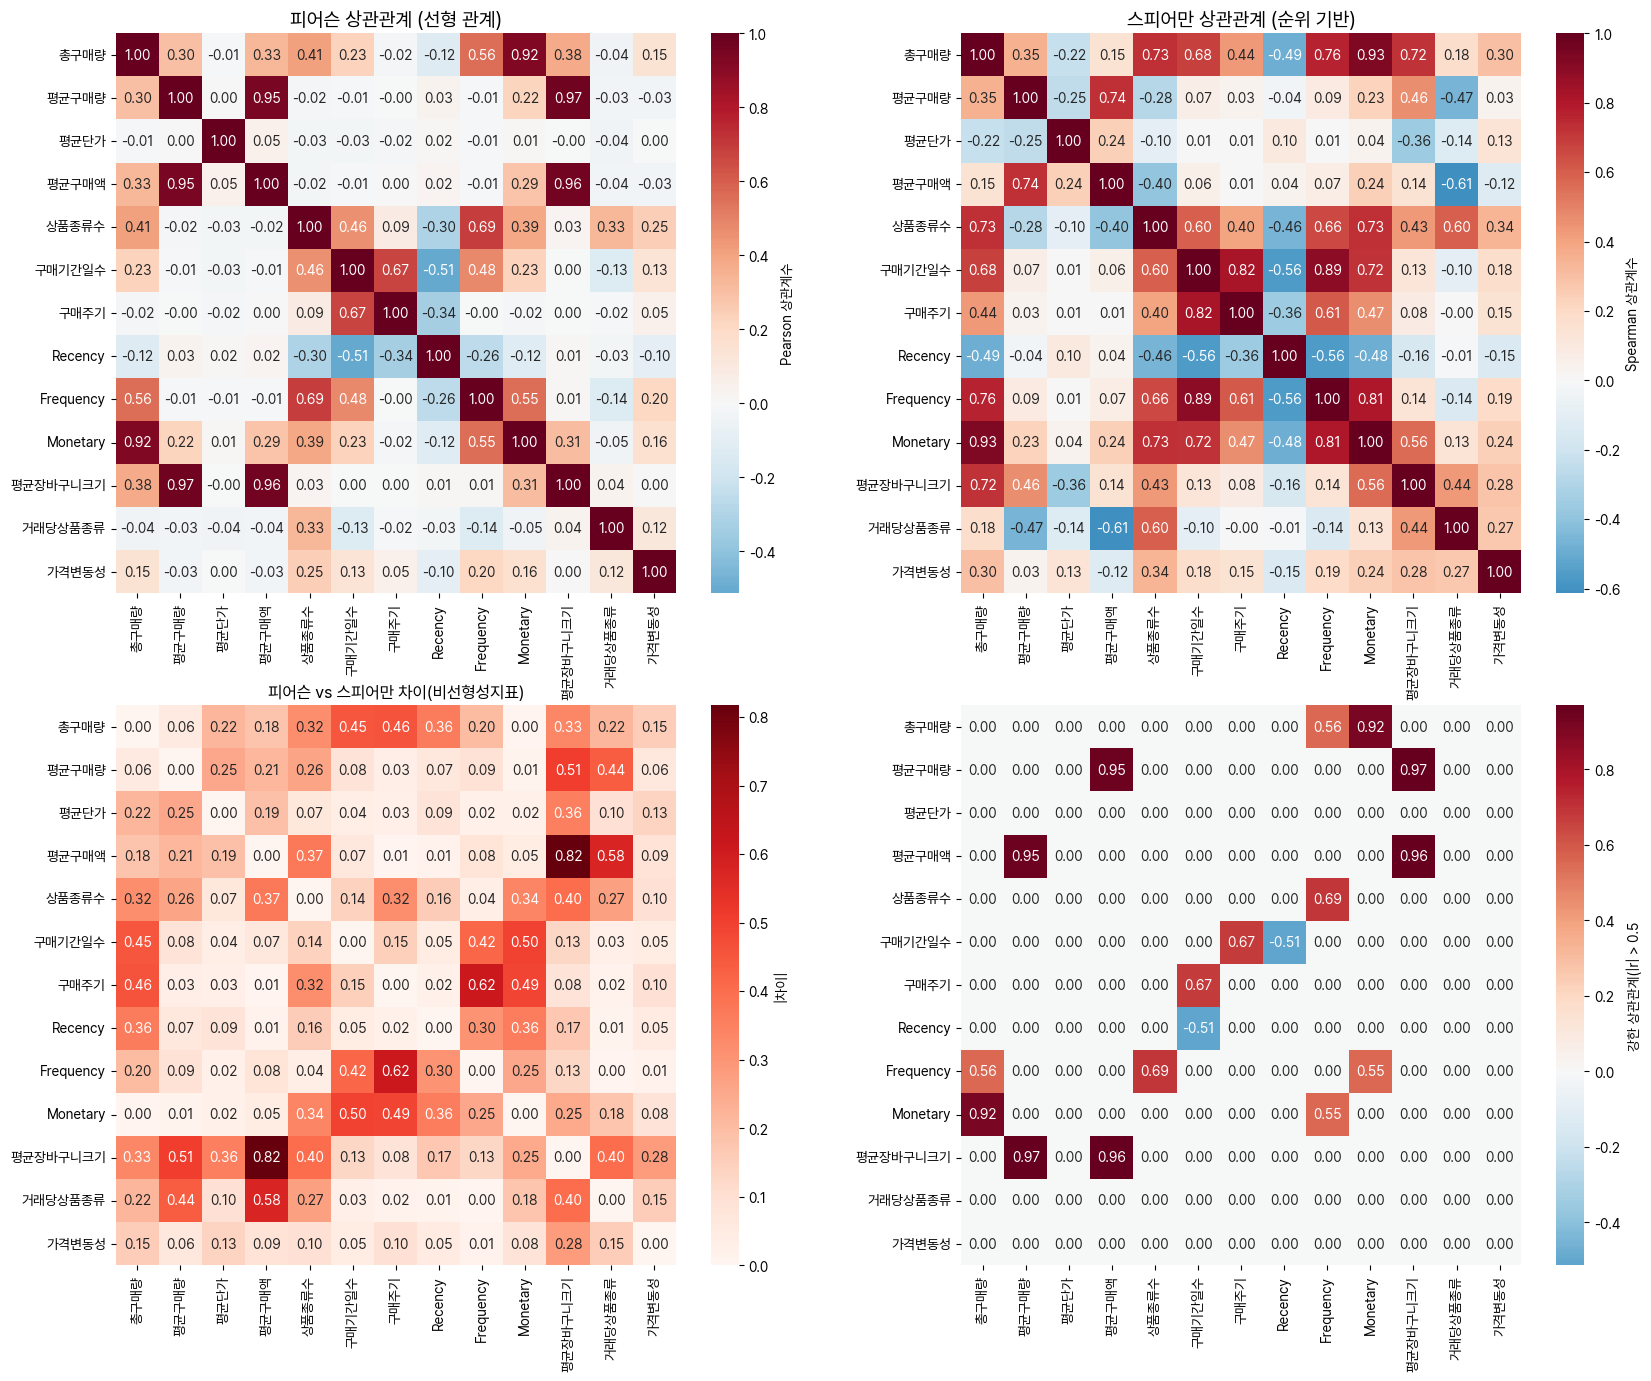

In [170]:
pearson_corr = correlation_data.corr(method='pearson')

spearman_corr = correlation_data.corr(method='spearman')


fig, axes = plt.subplots(2, 2, figsize=(20, 16))
a1, a2, a3, a4 = axes[0,0], axes[0,1], axes[1,0], axes[1,1]

# 피어슨 상관관계 히트맵 -> 키 : 몸무게 / 온도 : 전력
sns.heatmap(pearson_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, ax=a1, cbar_kws={'label': 'Pearson 상관계수'})
a1.set_title('피어슨 상관관계 (선형 관계)', fontsize=14)

# 스피어만 상관관계 히트맵 -> 시험순위 : 대회순위 / 만족도 : 재구매의사
# 그래서 서열형 데이터를 갖고 상관관계 분석하려면 spearman을 씀
sns.heatmap(spearman_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, ax=a2, cbar_kws={'label': 'Spearman 상관계수'})
a2.set_title('스피어만 상관관계 (순위 기반)', fontsize=14)

corr_diff = abs(spearman_corr - pearson_corr)
sns.heatmap(corr_diff, annot=True, fmt='.2f', cmap='Reds',
             square=True, ax=a3, cbar_kws={'label': '|차이|'})
a3.set_title('피어슨 vs 스피어만 차이(비선형성지표)')
# 여기서 튀는 친구들이 비선형적인 애들임.

# 강한 상관관계 (|r| > 0.5) 네트워크
strong_corr = pearson_corr.copy()
strong_corr[abs(strong_corr) < 0.5] = 0
np.fill_diagonal(strong_corr.values, 0)
sns.heatmap(strong_corr, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
             square=True, ax=a4, cbar_kws={'label': '강한 상관관계(|r| > 0.5'})

print('\n===주요 상관관계 발견사항 ===')
# 상삼각행렬에 대해서
upper_triangle = np.triu(pearson_corr, k=1)
# 가장 큰 값(강한 상관관계)이 있는 index를 반환
strong_positive = np.unravel_index(np.argmax(upper_triangle), upper_triangle.shape)
max_corr = pearson_corr.iloc[strong_positive]
print(f'가장 강한 양의 상관관계: {max_corr:.3f}')
print(f'  {pearson_corr.index[strong_positive[0]]} x {pearson_corr.index[strong_positive[1]]}')

strong_negative = np.unravel_index(np.argmin(upper_triangle), upper_triangle.shape)
min_corr = pearson_corr.iloc[strong_negative]
print(f'가장 강한 음의 상관관계: {min_corr:.3f}')
print(f'  {pearson_corr.index[strong_negative[0]]} x {pearson_corr.index[strong_negative[1]]}')

In [172]:
# Monetary x Frequency 중 뭐가 더 크게 영향을 주는가 검토
print('매출 증대 핵심 요인')
monetary_corr = pearson_corr['Monetary'].abs().sort_values(ascending=False)
for factor, corr in monetary_corr.head(6).items():
    if factor != 'Monetary':
        print(f'  {factor}: {corr:.3f}')

print('\n고객 충성도 요인')
frequency_corr = pearson_corr['Frequency'].abs().sort_values(ascending=False)
for factor, corr in frequency_corr.head(6).items():
    if factor != 'Frequency':
        print(f'  {factor}: {corr:.3f}')

매출 증대 핵심 요인
  총구매량: 0.923
  Frequency: 0.554
  상품종류수: 0.387
  평균장바구니크기: 0.310
  평균구매액: 0.287

고객 충성도 요인
  상품종류수: 0.692
  총구매량: 0.558
  Monetary: 0.554
  구매기간일수: 0.477
  Recency: 0.261
